# Bipartite Attempt at Anomaly Detection (with some last minute final AD updates)

This is a basic implementation of the algorithm from [this paper](https://faculty.mccombs.utexas.edu/deepayan.chakrabarti/mywww/papers/icdm05.pdf) on toy data to gain an understanding of it.

In [42]:
from pyCP_APR import CP_APR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
import os.path
import gzip
import shutil
import datetime
import networkx as nx
import pickle
from scipy import stats
from scipy import sparse
import bz2
import random
import regex as re
from tqdm.notebook import tqdm
import scipy

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score

from IPython.display import clear_output

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tqdm.keras import TqdmCallback

Here we implement a toy example to understand how to implement the model.

In [2]:
array = np.random.randint(2, size=(10,15))

In [3]:
for i in range(array.shape[0]):
    array[i] = [1]*15
    
array[0] = [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]

In [4]:
res_nodes = []

for node in range(array.shape[0]):
    c = 0.15
    eps = 0.001
    q_node = np.zeros(array.shape[0]+array.shape[1])
    q_node[node] = 1
    q_node = q_node.transpose()

    u_a = np.array([1/(array.shape[0]+array.shape[1])]*(array.shape[0]+array.shape[1]))
    u_a_prev = np.zeros(u_a.shape)

    array_normed = array / array.sum(axis=0)
    array_transpose_normed = array.transpose() / array.sum(axis=1)
    while np.linalg.norm(u_a - u_a_prev) >= eps:
        u_a_prev = u_a

        a = np.dot(array_transpose_normed,u_a[:array.shape[0]])
        b = np.dot(array_normed,u_a[array.shape[0]:array.shape[0]+array.shape[1]])

        u_a = (1-c)*(np.concatenate([a,b]))+c*q_node

    res_nodes.append(u_a[:array.shape[0]])

res_nodes =pd.DataFrame(res_nodes)

anom_scores = []

for node in range(array.shape[0]):
    S_t = np.where(array[:,node] == 1)
    r_matrix = np.array(res_nodes.iloc[(S_t[0],S_t[0])])
    anom_scores.append(np.mean(np.diagonal(r_matrix)))

anom_scores

[0.1712653932524548,
 0.1712653932524548,
 0.1712653932524548,
 0.1712653932524548,
 0.1712653932524548,
 0.1712653932524548,
 0.17076019599371497,
 0.1712653932524548,
 0.1712653932524548,
 0.1712653932524548]

This didn't seem to work here - doing this very late on in the project so I'm not sure why at the moment.

In [26]:
try:
    print('Attempting to read entire data set.')
    authentication_data = pd.read_csv('C:/Users/corri/OneDrive/Documents/GitHub/Advanced-Cyber-Analytics-for-Attack-Detection/Data/Authentication data.gz', compression='gzip', index_col = 0)
    process_data = pd.read_csv('C:/Users/corri/OneDrive/Documents/GitHub/Advanced-Cyber-Analytics-for-Attack-Detection/Data/Process data.gz', compression='gzip', index_col = 0)
except:
    clear_output()
    print('Unable to read entire data set, reading from original files.')
    rootdir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls'
    unzippeddir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls/Unzipped'
    frames = []

    count = 0
    
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file[-3:] == '.gz':
                filedir = rootdir + '/' + file
                with gzip.open(filedir) as f:
                    df = pd.read_csv(filedir, header=None)
                    frames.append(df)
                if 'authentications' in str(file):
                    count = count + len(df)
    
    df = pd.concat(frames)

    authentication_data = df[:count]
    authentication_data.columns = ['UserName', 'SrcDevice','DstDevice', 'Authent Type', 'Failure', 'DailyCount']

    process_data = df[count:]
    process_data = process_data[[0,1,2,3,4]]
    process_data.columns = ['UserName', 'Device', 'ProcessName', 'ParentProcessName', 'DailyCount']

    authentication_data.to_csv('../Data/Authentication data.gz', header=True, compression='gzip')
    process_data.to_csv('../Data/Process data.gz', header=True, compression='gzip')

Attempting to read entire data set.


C:\Users\corri\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [54]:
rt_usernames = list(pd.read_csv('../../../Data/AuthUserNames.txt', header=None)[0])
non_rt_users = [un for un in authentication_data['UserName'].unique() if un not in rt_usernames]
non_rt_sample = pickle.load(open('../Final Anomaly Detection/Random Sample of Non Red Team Usernames.p','rb'))

In [56]:
auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))

In [36]:
def split_dataframe(df,n):
    chunks = list()
    chunk_size = int(np.round(df.shape[0]/n))
    num_chunks = n
    for i in range(num_chunks):
        if i != num_chunks-1:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
        else:
            chunks.append(df[i*chunk_size:])
    return chunks

In [37]:
def auth_type_un_df(user,n):
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n
    auth_type_dict = {}
    
    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type')['DailyCount'].sum()
                auth_type_dict[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())
    
    auth_type_df = pd.DataFrame(data=auth_type_dict,index = list(authentication_data['Authent Type'].unique()))
    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    return auth_type_df

In [38]:
def feature_generation(user,n):
    
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                hour = j
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data.groupby(['SrcDevice','DstDevice']).size())
                feat_dict[i*n + j] = [srcunique,dstunique,authents,failures]
                #feat_dict[i*n + j] = [day,hour,srcunique,dstunique,uniquepairs,authents,failures]
                
    df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures'])
    #df = pd.DataFrame(data=feat_dict,index =  ['Day','Hour','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df = df.transpose()
    df = df.fillna(0)
    
    return df

In [47]:
columns_sparse = pickle.load(open('../Final Anomaly Detection/Columns UASE.p','rb'))

In [49]:
try:
    print('Reading Data.')
    data_frame_list_uase = pickle.load(open('C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/Data Frame List UASE.p','rb'))
    index_sparse = pickle.load(open('../Final Anomaly Detection/Index UASE.p','rb'))
    columns_sparse = pickle.load(open('../Final Anomaly Detection/Columns UASE.p','rb'))
    
except:
    clear_output()
    print('Creating Data Frames.')
    data_frame_list_uase = []

    start_time = datetime.datetime.now()

    for i in tqdm(range(len(auth_start_days)-1)):

        data_frame_ind = pd.DataFrame(index = list(authentication_data['DstDevice'].unique()))

        chunk = authentication_data[auth_start_days[i]:auth_start_days[i+1]]
        data_un ={}
        for user in authentication_data['UserName'].unique():
            dstdevice_data = chunk[chunk['UserName'] == user].groupby('DstDevice').size()
            data_un[user] = data_frame_ind.index.to_series().map(dstdevice_data.to_dict())

        data_frame_ind = pd.DataFrame(data=data_un,index = list(authentication_data['DstDevice'].unique()))
        data_frame_ind = data_frame_ind.notnull().astype('int')
        data_frame_ind = data_frame_ind.fillna(0)
        A = np.array(data_frame_ind)
        sA = sparse.csr_matrix(A)
        data_frame_list_uase.append(sA)    

    index_sparse = data_frame_ind.index
    columns_sparse = data_frame_ind.columns
    pickle.dump(data_frame_list_uase, open('Data Frame List UASE.p', 'wb'))
    pickle.dump(index_sparse, open('Index UASE.p', 'wb'))
    pickle.dump(columns_sparse, open('Columns UASE.p', 'wb'))
    print(datetime.datetime.now()-start_time)

Reading Data.


In [63]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#000000', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

#fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
#fig.savefig("table_mpl.png")

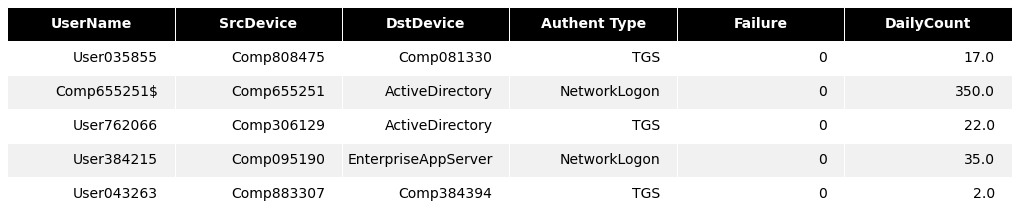

In [231]:
fig,ax = render_mpl_table(authentication_data.head(), header_columns=0, col_width=3.0)
fig.savefig("authentication data mpl.png")

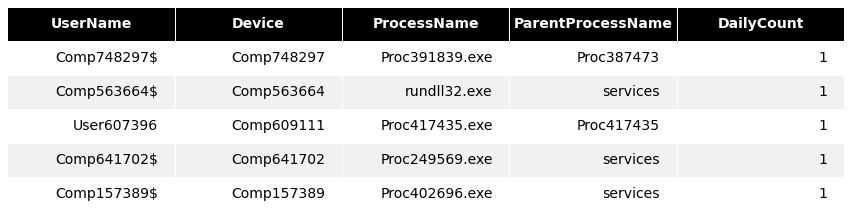

In [233]:
fig,ax = render_mpl_table(process_data.head(), header_columns=0, col_width=3.0)
fig.savefig("process data mpl.png")

In [70]:
dt = feature_generation(rt_usernames[0],24)

In [205]:
data_frame_ind = pd.DataFrame(index = list(authentication_data['DstDevice'].unique()))
chunk = authentication_data[auth_start_days[1]:auth_start_days[2]]
data_un ={}
for user in tqdm(authentication_data['UserName'].unique()):
    dstdevice_data = chunk[chunk['UserName'] == user].groupby('DstDevice').size()
    data_un[user] = data_frame_ind.index.to_series().map(dstdevice_data.to_dict())

data_frame_ind = pd.DataFrame(data=data_un,index = list(authentication_data['DstDevice'].unique()))
data_frame_ind = data_frame_ind.notnull().astype('int')
data_frame_ind = data_frame_ind.fillna(0)

  0%|          | 0/28815 [00:00<?, ?it/s]

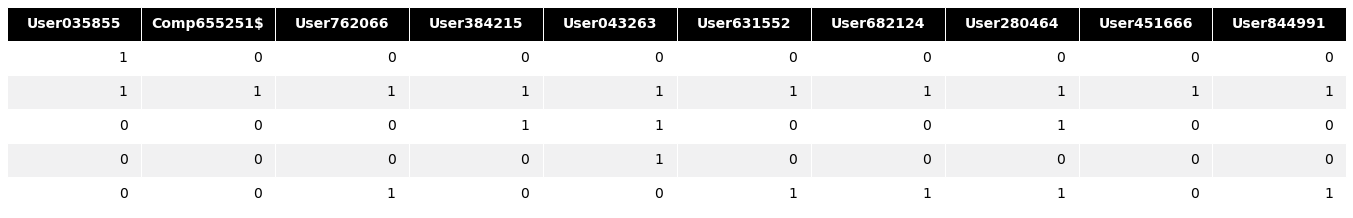

In [218]:
fig,ax = render_mpl_table(data_frame_ind.iloc[0:5,0:10],col_width=2.4)
fig.savefig("Graph Adjacency Array Example.png")

In [72]:
def feature_generation_2(user,n):
    
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                hour = j
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data.groupby(['SrcDevice','DstDevice']).size())
                #feat_dict[i*n + j] = [srcunique,dstunique,authents,failures]
                feat_dict[i*n + j] = [day,hour,srcunique,dstunique,uniquepairs,authents,failures]
                
    #df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures'])
    df = pd.DataFrame(data=feat_dict,index =  ['Day','Hour','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df = df.transpose()
    df = df.fillna(0)
    
    return df

In [133]:
def feature_generation_3(user,n):
    
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n
    auth_type_dict = {}
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data[data['UserName'] == user].groupby(['SrcDevice','DstDevice']).size())
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type')['DailyCount'].sum()
                auth_type_dict[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())
                #feat_dict[i*n + j] = [srcunique,dstunique,authents,failures]
                feat_dict[i*n + j] = [day,srcunique,dstunique,uniquepairs,authents,failures]
                
    #df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures'])
    df1 = pd.DataFrame(data=feat_dict,index =  ['Day','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df1 = df1.transpose()
    df1 = df1.fillna(0)
    
    auth_type_df = pd.DataFrame(data=auth_type_dict,index = list(authentication_data['Authent Type'].unique()))
    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    df = pd.concat([df1, auth_type_df], axis=1)
    
    return df

In [223]:
df = feature_generation_3(rt_usernames[0],24)

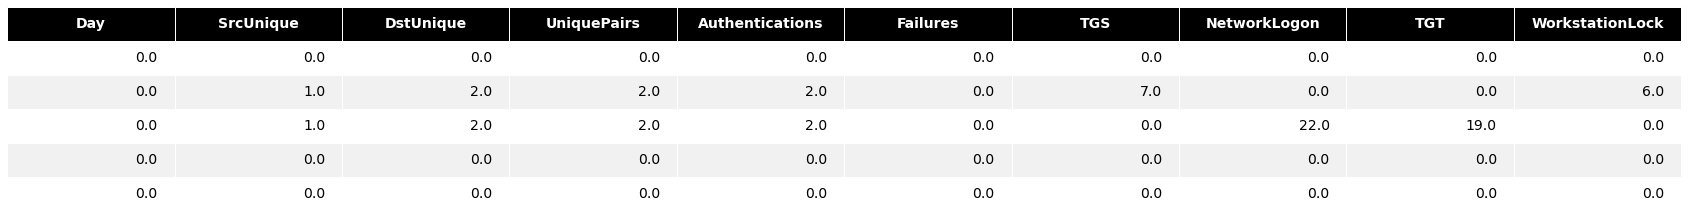

In [227]:
fig,ax = render_mpl_table(df.iloc[0:5,0:10])
fig.savefig("Count Based Array Example.png")

In [73]:
def ae_orig_finder(user,n,idx):
    
    j_idx = idx % n
    i_idx = int(idx/n)

    chunks = split_dataframe(authentication_data[auth_start_days[i_idx]:auth_start_days[i_idx+1]],n)
    data = chunks[j_idx][chunks[j_idx]['UserName'] == user]
    
    return data

In [94]:
anomalies_ae_5['index'] = anomalies_ae_5.index

In [161]:
def poiss_orig_finder(user,n,idx):
    
    j_idx = idx % n
    i_idx = int(idx/n)

    chunks = split_dataframe(authentication_data[auth_start_days[i_idx]:auth_start_days[i_idx+1]],n)
    data = chunks[j_idx][chunks[j_idx]['UserName'] == user]
    data['Hour'] = [j_idx]*len(data)
    data['Day'] = [i_idx+1]*len(data)
    
    return data

In [98]:
def inhom_poiss_ae_detection_2(usernames,n,comb,alpha=1,beta=1):
    events_frames = []
    
    for (un_ct,un) in enumerate(usernames):
        
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(un_ct+1,len(usernames),100*((un_ct+1)/len(usernames))))
        pois_df = auth_type_un_df(un,n)
        bayes_mean = []
        bayes_var = []
        alpha = alpha
        beta = beta

        f_probs = []

        for i in range(n):
            bayes_mean_hr = []
            bayes_var_hr = []
            for col in pois_df.columns:
                dt = list(pd.concat([pois_df.iloc[:57*n],pois_df.iloc[83*n:]])[col])
                dt_hspl = dt[i::n]
                bayes_mean_hr.append((alpha+sum(dt_hspl))/(beta+len(dt_hspl)))
                bayes_var_hr.append((alpha+sum(dt_hspl))/(beta+len(dt_hspl))**2)

            bayes_mean.append(bayes_mean_hr)
            bayes_var.append(bayes_var_hr)
        
        find_prob = []
        for i in range(n):
            find_prob.append(pd.DataFrame(stats.poisson.pmf(pd.concat([pois_df.iloc[:57*n], pois_df.iloc[83*n:]]).iloc[i::n],bayes_mean[i])).min())
                
        probabilities = []
        
        for i in range(n):

            probabilities.append(stats.poisson.pmf(pois_df.iloc[57*n:82*n].iloc[i::n],bayes_mean[i]))

        for i in range(n):

            probs = probabilities[i]

            for j in range(len(probs)):

                hr_prob = probs[j]
                
                thresh = find_prob[i]
                
                if [item1 for item1,item2 in zip(hr_prob,thresh) if item1 <= item2] != []:

                    events_frames.append(poiss_orig_finder(un,n,57*n+j*n+i))

    events = pd.concat(events_frames)
    
    return events

In [100]:
def simple_poiss_eval(anomaly_bools,anomalies,usernames,type_un):
    
    non_anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] == 0:    
            non_anom.append(anomaly_bools[i][1])

    anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] != 0:    
            anom.append(anomaly_bools[i][1])
    
    print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
          format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
    print('--------------------------------------------------------------------------------------------')        
    print(', '.join(map(str,non_anom)))
    
    perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
    print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))
    
    print(anomalies.groupby('Authent Type').size())
    
    anomalies.head()
    
    return

In [162]:
s_time = datetime.datetime.now()
poisson_anoms_inhom = inhom_poiss_ae_detection_2(rt_usernames,24,False)

poisson_anoms_inhom = poisson_anoms_inhom.drop_duplicates()
poiss_anom_bool_inhom = []

for un in rt_usernames:
    if un in list(poisson_anoms_inhom['UserName']):
        poiss_anom_bool_inhom.append((1,un))
    else:
        poiss_anom_bool_inhom.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)

Working with username 99 of 99. 100.00 percentage complete.
0:09:23.963495


In [163]:
simple_poiss_eval(poiss_anom_bool_inhom,poisson_anoms_inhom,rt_usernames,'red team')

98 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
30.20% of the red team data was identified as anomalous.
Authent Type
Batch                     566
CachedInteractive         187
InteractiveLogon         1217
NetworkLogon            16197
RemoteInteractive         404
ScreensaverDismissed      484
ScreensaverInvoked        476
Service                  1136
TGS                     17771
TGT                      4782
WorkstationLock          1160
WorkstationUnlock        1467
dtype: int64


In [199]:
s_time = datetime.datetime.now()

inhom_poisson_anoms_n = inhom_poiss_ae_detection_2(non_rt_sample,24,False)

inhom_poisson_anoms_n = inhom_poisson_anoms_n.drop_duplicates()
inhom_poiss_anom_bool_n = []

for un in non_rt_sample:
    if un in list(inhom_poisson_anoms_n['UserName']):
        inhom_poiss_anom_bool_n.append((1,un))
    else:
        inhom_poiss_anom_bool_n.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(inhom_poiss_anom_bool_n,inhom_poisson_anoms_n,non_rt_sample,'normal')

Working with username 200 of 200. 100.00 percentage complete.
0:18:36.448601
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
29.18% of the normal data was identified as anomalous.
Authent Type
CachedInteractive          20
InteractiveLogon          465
NetworkLogon             9109
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        252
Service                     4
TGS                     12631
TGT                      3188
WorkstationLock           641
WorkstationUnlock         864
dtype: int64


In [74]:
def simple_ae_eval(anomaly_bools,anomalies,val_losses,usernames,type_un):
    
    non_anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] == 0:    
            non_anom.append(anomaly_bools[i][1])

    anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] != 0:    
            anom.append(anomaly_bools[i][1])
    
    print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
          format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
    print('--------------------------------------------------------------------------------------------')        
    print(', '.join(map(str,non_anom)))
    
    perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
    print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))
    
    final_losses = []
    for i in range(len(val_losses)):
        final_losses.append(val_losses[i][0][len(val_losses[i][0])-1]) 

    plt.figure()
    sns.boxplot(data = final_losses)
    plt.show()
    
    print(anomalies.groupby('Authent Type').size())
    
    anomalies.head()
    
    return

In [75]:
def ae_anomaly_finder_2(user,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the data frame of features
    df = feature_generation_2(user,n)
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [80]:
frames_5 = []
anomaly_bool_5 = []
val_loss_5 = []

s_time = datetime.datetime.now()

for i,un in tqdm(enumerate(set(rt_usernames))):
    clear_output(wait=True)
    print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
    f,b,val = ae_anomaly_finder_2(un,24)
    if b == 1:
        frames_5.append(f)
        anomaly_bool_5.append((len(f),un))
        val_loss_5.append((val,un))
    else:
        anomaly_bool_5.append((0,un))
        val_loss_5.append((val,un))
        pass
anomalies_ae_5 = pd.concat(frames_5)

e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
0:32:03.110475


84 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User133028, User222822, User497510, User089536, User457932, User758916, User900703, User409683, User859748, User829941, User630088
27.07% of the red team data was identified as anomalous.


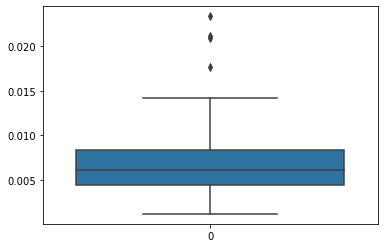

Authent Type
Batch                     539
CachedInteractive         139
InteractiveLogon         1193
NetworkLogon            12278
RemoteInteractive         342
ScreensaverDismissed      446
ScreensaverInvoked        432
Service                  1128
TGS                     17300
TGT                      4843
WorkstationLock          1104
WorkstationUnlock        1349
dtype: int64


In [81]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team')

In [118]:
frames_n_5 = []
anomaly_bool_N_5 = []
val_loss_n_5 = []
bound = 400

s_time = datetime.datetime.now()

for i,un in tqdm(enumerate(non_rt_sample)):
    f,b,val = ae_anomaly_finder_2(un,24)
    if b == 1:
        frames_n_5.append(f)
        anomaly_bool_N_5.append((len(f),un))
        val_loss_n_5.append((val,un))
    else:
        anomaly_bool_N_5.append((0,un))
        val_loss_n_5.append((val,un))
        pass
anomalies_ae_n_5 = pd.concat(frames_n_5)
pickle.dump(anomalies_ae_n_5,open('Non RT Anomalies.p','wb'))
pickle.dump(val_loss_n_5,open('Non RT VL.p','wb'))
pickle.dump(non_rt_sample,open('Random Sample of Non Red Team Usernames.p','wb'))
e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
1:06:35.479170


177 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User401689, Comp362353$, Comp393779$, User319750, Comp740988$, Comp674474$, Comp089988$, User108742, Comp388786$, User184125, Comp498283$, Comp682953$, Comp985400$, User392061, User319181, User924320, User140503, Comp722112$, User569089, User494395, User793668, Comp288826$, Comp120148$
26.26% of the normal data was identified as anomalous.


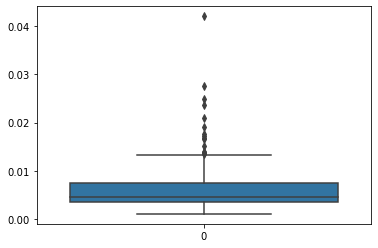

Authent Type
CachedInteractive          32
InteractiveLogon          441
NetworkLogon             7247
RemoteInteractive          68
ScreensaverDismissed      209
ScreensaverInvoked        204
Service                     2
TGS                     12061
TGT                      3135
WorkstationLock           583
WorkstationUnlock         765
dtype: int64


In [119]:
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

In [120]:
MCC(84,23,177,11)

(array([36.27118644, 32.18390805, 88.42105263, 88.5       ]),
 -0.0011551935261435752)

In [146]:
def ae_orig_finder_3(user,n,idx):
    
    j_idx = idx % n
    i_idx = int(idx/n)
    
    chunks = split_dataframe(authentication_data[auth_start_days[i_idx]:auth_start_days[i_idx+1]],n)
    data = chunks[j_idx][chunks[j_idx]['UserName'] == user]
    data['Hour'] = [j_idx]*len(data)
    data['Day'] = [i_idx+1]*len(data)
    return data

In [184]:
def ae_anomaly_finder_3(user,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the data frame of features
    df = feature_generation_3(user,n)
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    print(anomaly_idx)
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder_3(user,n,57*n+anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [186]:
frames_5 = []
anomaly_bool_5 = []
val_loss_5 = []

s_time = datetime.datetime.now()

for i,un in tqdm(enumerate(set(rt_usernames))):
    clear_output(wait=True)
    print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
    f,b,val = ae_anomaly_finder_3(un,24)
    if b == 1:
        frames_5.append(f)
        anomaly_bool_5.append((len(f),un))
        val_loss_5.append((val,un))
    else:
        anomaly_bool_5.append((0,un))
        val_loss_5.append((val,un))
        pass
anomalies_ae_5 = pd.concat(frames_5)

e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
[  4   5   6   8  10  13  15  16  28  29  30  32  34  37  39  40  44  48
  52  53  54  56  57  58  61  63  64  66  71  74  81  83  84  85  88  89
  93 101 107 108 109 114 115 122 126 129 131 137 141 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 172 173 174 176 178 181 183 184 196 197 198 200 202 205 207 208 209
 215 220 221 222 224 226 229 231 232 244 245 246 248 250 253 255 256 266
 273 277 280 281 285 290 297 299 301 304 305 309 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 340 341 342 344 346 349 351 352 364 365 366 368 370 373 375 376 378 383
 388 390 392 393 394 397 399 400 412 413 414 416 418 421 423 424 434 438
 441 449 453 462 475 480 481 482 483 484 485 486 487 488 489 490 491 492
 493 494 495 496 497 498 499 500 501 502 503 508 509 510 512 514 517 519
 520 524 525 532 533 534 536 538 541 543

C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:28:47.650311


94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
27.77% of the red team data was identified as anomalous.


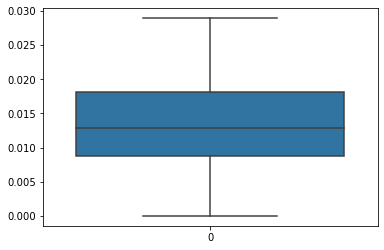

Authent Type
Batch                     479
CachedInteractive         181
InteractiveLogon         1126
NetworkLogon            14443
RemoteInteractive         365
ScreensaverDismissed      483
ScreensaverInvoked        475
Service                   780
TGS                     16932
TGT                      4272
WorkstationLock          1158
WorkstationUnlock        1466
dtype: int64


In [187]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team')

In [188]:
frames_n_5 = []
anomaly_bool_N_5 = []
val_loss_n_5 = []
bound = 400

s_time = datetime.datetime.now()

for i,un in tqdm(enumerate(non_rt_sample)):
    f,b,val = ae_anomaly_finder_3(un,24)
    if b == 1:
        frames_n_5.append(f)
        anomaly_bool_N_5.append((len(f),un))
        val_loss_n_5.append((val,un))
    else:
        anomaly_bool_N_5.append((0,un))
        val_loss_n_5.append((val,un))
        pass
anomalies_ae_n_5 = pd.concat(frames_n_5)
pickle.dump(anomalies_ae_n_5,open('Non RT Anomalies.p','wb'))
pickle.dump(val_loss_n_5,open('Non RT VL.p','wb'))
pickle.dump(non_rt_sample,open('Random Sample of Non Red Team Usernames.p','wb'))
e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
[  0   1   5   6   7  10  11  13  15  16  24  25  30  31  32  34  37  39
  40  48  49  53  54  55  56  58  59  61  63  64  70  71 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 173 174 175 176 177 178 179 181 182 183 184 186
 187 188 190 191 192 193 197 198 199 200 202 203 205 207 208 211 214 216
 217 218 222 223 224 226 227 228 229 231 232 233 238 239 312 313 314 315
 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333
 334 335 336 337 341 342 343 344 346 347 349 351 352 355 358 360 361 365
 366 367 368 370 371 373 375 376 382 383 384 385 389 390 391 392 394 395
 396 397 399 400 401 480 481 482 483 484 485 486 487 488 489 490 491 492
 493 494 495 496 497 498 499 500 501 502 503 504 505 508 509 510 511 512
 514 515 516 517 519 520 521 528 529 533 534 535 536 537 538 539 540 541
 543 544 545 553 556 557 558 559 560 562

C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:56:12.662801


179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
29.18% of the normal data was identified as anomalous.


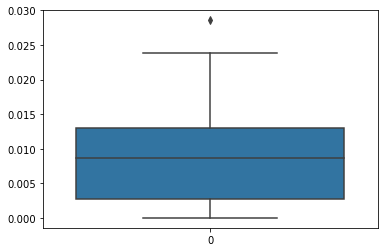

Authent Type
CachedInteractive          20
InteractiveLogon          465
NetworkLogon             9109
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        252
Service                     4
TGS                     12631
TGT                      3188
WorkstationLock           641
WorkstationUnlock         864
dtype: int64


In [189]:
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

In [194]:
MCC(94,21,179,1)

(array([38.98305085, 34.43223443, 98.94736842, 89.5       ]),
 0.16803315759376639)

In [191]:
poisson_anoms_inhom[['Hour','Day']] = poisson_anoms_inhom[['Hour','Day']].astype('int')

In [201]:
final_anomalies = pd.merge(anomalies_ae_5, poisson_anoms_inhom, how='inner', on=list(poisson_anoms_inhom.columns))
final_normal_anomalies = pd.merge(anomalies_ae_n_5, inhom_poisson_anoms_n, how='inner', on=list(inhom_poisson_anoms_n.columns))

In [203]:
final_anom_bool_n = []
final_anom_bool = []

for un in non_rt_sample:
    if un in list(final_normal_anomalies['UserName']):
        final_anom_bool_n.append((1,un))
    else:
        final_anom_bool_n.append((0,un))
for un in set(rt_usernames):
    if un in list(final_anomalies['UserName']):
        final_anom_bool.append((1,un))
    else:
        final_anom_bool.append((0,un))
simple_poiss_eval(final_anom_bool,final_anomalies,rt_usernames,'red team')
simple_poiss_eval(final_anom_bool_n,final_normal_anomalies,non_rt_sample,'normal')

94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
27.77% of the red team data was identified as anomalous.
Authent Type
Batch                     479
CachedInteractive         181
InteractiveLogon         1126
NetworkLogon            14443
RemoteInteractive         365
ScreensaverDismissed      483
ScreensaverInvoked        475
Service                   780
TGS                     16932
TGT                      4272
WorkstationLock          1158
WorkstationUnlock        1466
dtype: int64
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, 

In [235]:
def feature_generation_4(user,n):
    
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n
    auth_type_dict = {}
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        if day <= 4:
            weekday = 1
            weekend = 0
        else:
            weekday = 0
            weekend = 1
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data[data['UserName'] == user].groupby(['SrcDevice','DstDevice']).size())
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type')['DailyCount'].sum()
                auth_type_dict[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())
                #feat_dict[i*n + j] = [srcunique,dstunique,authents,failures]
                feat_dict[i*n + j] = [weekday,weekend,srcunique,dstunique,uniquepairs,authents,failures]
                
    #df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures'])
    df1 = pd.DataFrame(data=feat_dict,index =  ['Weekday','Weekend','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df1 = df1.transpose()
    df1 = df1.fillna(0)
    
    auth_type_df = pd.DataFrame(data=auth_type_dict,index = list(authentication_data['Authent Type'].unique()))
    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    df = pd.concat([df1, auth_type_df], axis=1)
    
    return df

In [236]:
def ae_anomaly_finder_4(user,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the data frame of features
    df = feature_generation_4(user,n)
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    print(anomaly_idx)
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder_3(user,n,57*n+anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [237]:
frames_5 = []
anomaly_bool_5 = []
val_loss_5 = []

s_time = datetime.datetime.now()

for i,un in tqdm(enumerate(set(rt_usernames))):
    clear_output(wait=True)
    print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
    f,b,val = ae_anomaly_finder_4(un,24)
    if b == 1:
        frames_5.append(f)
        anomaly_bool_5.append((len(f),un))
        val_loss_5.append((val,un))
    else:
        anomaly_bool_5.append((0,un))
        val_loss_5.append((val,un))
        pass
anomalies_ae_5 = pd.concat(frames_5)

e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
[  4   5   6   8  10  13  15  16  28  29  30  32  34  37  39  40  44  48
  52  53  54  56  57  58  61  63  64  66  71  74  81  83  84  85  88  89
  93 101 107 108 109 114 115 122 126 129 131 137 141 148 149 150 152 154
 157 159 160 172 173 174 176 178 181 183 184 196 197 198 200 202 205 207
 208 209 215 220 221 222 224 226 229 231 232 244 245 246 248 250 253 255
 256 266 273 277 280 281 285 290 297 299 301 304 305 309 316 318 320 321
 322 325 327 328 340 341 342 344 346 349 351 352 364 365 366 368 370 373
 375 376 378 383 388 390 392 393 394 397 399 400 412 413 414 416 418 421
 423 424 434 438 441 449 453 462 475 484 485 486 488 489 490 493 495 496
 500 508 509 510 512 514 517 519 520 524 525 532 533 534 536 538 541 543
 544 556 557 558 560 562 565 567 568 572 580 581 582 584 586 589 591 592]


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:34:26.447171


94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
26.06% of the red team data was identified as anomalous.


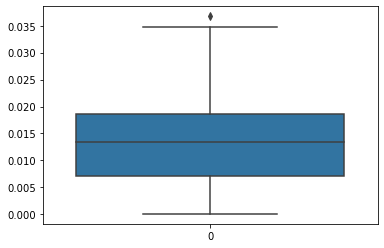

Authent Type
Batch                     359
CachedInteractive         167
InteractiveLogon         1016
NetworkLogon            13380
RemoteInteractive         331
ScreensaverDismissed      481
ScreensaverInvoked        471
Service                   632
TGS                     16185
TGT                      3954
WorkstationLock          1147
WorkstationUnlock        1446
dtype: int64


In [238]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team')

In [245]:
[anomaly_bool_5[i][1] for i in range(len(anomaly_bool_5)) if anomaly_bool_5[i][0] == 0]

['User405399']

In [248]:
for i in range(len(auth_start_days)-1):
    data = authentication_data[auth_start_days[i]:auth_start_days[i+1]]
    test = data[data['UserName'] == 'User405399']
    if len(test) >= 1:
        print('Events occur in day {}.'.format(i))

Events occur in day 21.


The reason that this user isnt identified in any events is because no events occur on those days in the summary data during the pen test period.

In [239]:
frames_n_5 = []
anomaly_bool_N_5 = []
val_loss_n_5 = []

s_time = datetime.datetime.now()

for i,un in tqdm(enumerate(non_rt_sample)):
    f,b,val = ae_anomaly_finder_4(un,24)
    if b == 1:
        frames_n_5.append(f)
        anomaly_bool_N_5.append((len(f),un))
        val_loss_n_5.append((val,un))
    else:
        anomaly_bool_N_5.append((0,un))
        val_loss_n_5.append((val,un))
        pass
anomalies_ae_n_5 = pd.concat(frames_n_5)
pickle.dump(anomalies_ae_n_5,open('Non RT Anomalies.p','wb'))
pickle.dump(val_loss_n_5,open('Non RT VL.p','wb'))
pickle.dump(non_rt_sample,open('Random Sample of Non Red Team Usernames.p','wb'))
e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
[  0   1   5   6   7  10  11  13  15  16  24  25  30  31  32  34  37  39
  40  48  49  53  54  55  56  58  59  61  63  64  70  71 144 145 149 150
 151 152 154 155 157 159 160 161 163 166 167 168 169 170 171 173 174 175
 176 177 178 179 181 182 183 184 186 187 188 190 191 192 193 197 198 199
 200 202 203 205 207 208 211 214 216 217 218 222 223 224 226 227 228 229
 231 232 233 238 239 312 313 317 318 319 320 322 323 325 327 328 329 334
 335 336 337 341 342 343 344 346 347 349 351 352 355 358 360 361 365 366
 367 368 370 371 373 375 376 382 383 384 385 389 390 391 392 394 395 396
 397 399 400 401 480 481 485 486 487 488 490 491 493 495 496 497 502 504
 505 508 509 510 511 512 514 515 516 517 519 520 521 528 529 533 534 535
 536 537 538 539 540 541 543 544 545 553 556 557 558 559 560 562 563 564
 565 567 568 569 571 575]


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


1:02:26.607031


179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
29.18% of the normal data was identified as anomalous.


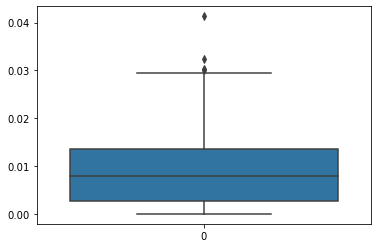

Authent Type
CachedInteractive          20
InteractiveLogon          465
NetworkLogon             9109
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        252
Service                     4
TGS                     12631
TGT                      3188
WorkstationLock           641
WorkstationUnlock         864
dtype: int64


In [240]:
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

In [251]:
for un in [anomaly_bool_N_5[i][1] for i in range(len(anomaly_bool_N_5)) if anomaly_bool_N_5[i][0] == 0]:
    for i in range(len(auth_start_days)-1):
        data = authentication_data[auth_start_days[i]:auth_start_days[i+1]]
        test = data[data['UserName'] == 'User405399']
        if len(test) >= 1:
            print('Events for username {} occur in day {}.'.format(un,i))

Events for username Comp792408$ occur in day 21.
Events for username Comp166939$ occur in day 21.
Events for username User835130 occur in day 21.
Events for username Comp982997$ occur in day 21.
Events for username Comp220136$ occur in day 21.
Events for username User034060 occur in day 21.
Events for username Comp421434$ occur in day 21.
Events for username User681533 occur in day 21.
Events for username User658064 occur in day 21.
Events for username User108742 occur in day 21.
Events for username Comp282554$ occur in day 21.
Events for username Comp556020$ occur in day 21.
Events for username Comp834308$ occur in day 21.
Events for username Comp682953$ occur in day 21.
Events for username Comp156369$ occur in day 21.
Events for username User611055 occur in day 21.
Events for username User248771 occur in day 21.
Events for username User924320 occur in day 21.
Events for username Comp722112$ occur in day 21.
Events for username Comp360389$ occur in day 21.
Events for username Comp8559

Similarly, those usernames that are not detected to have anomalies have no events during the penetration test. Thus we may assume from this that all usernames identified would have 100% FPR and 100% recall.

In [270]:
cfm = pd.DataFrame(data=[[94,1],[179,21]], columns=['Predicted: Positive','Predicted: Negative'], index=['Actual: Positive','Actual: Negative'])

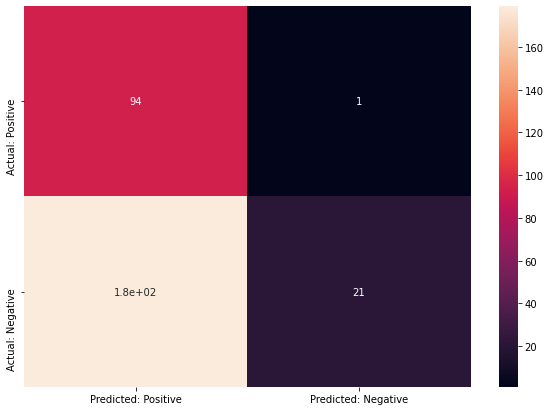

In [271]:
fig = plt.figure(figsize = (10,7))
sns.heatmap(cfm, annot=True)
fig.savefig("Conf Mat AE P.png")